## Implementation

In [ ]:
import os
import numpy as np
import pandas as pd
import zipfile
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

### Download the dataset from kaggle

In [ ]:
!kaggle datasets download -d vencerlanz09/bottle-synthetic-images-dataset

In [ ]:
# Unzip the downloaded bottle-synthetic-images-dataset
with zipfile.ZipFile('bottle-synthetic-images-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('bottle-synthetic-images-dataset')

### Load images and collect their file paths
Note that, to make it less time-consuming, the number of images per label was sampled to 3000.

To load the images from the file path, and resize the images -> some methods of *tensorflow.keras.preprocessing.image* library used.

The pixel values of the images vary from 0 to 255. Scaled these values from 0 to 1.


In [ ]:
def resize_image(image_path):
    # target size of the images (64, 64)
    image = load_img(image_path, target_size=(64, 64))
    # to scale the images, divide the values by 255
    image_array = img_to_array(image) / 255.0
    images.append(image_array)
    return images

A function required to take the images from each folder.

In [ ]:
max_images_per_label = 3000

def load_images_per_file(label_dir,label,images,filepath_label,count):
    # used tf methods to reach the paths.
    for image_name in tf.io.gfile.listdir(label_dir):
        image_path = os.path.join(label_dir, image_name)
        try:
            images = resize_image(image_path)
            filepath_label.append((image_path, label))
            count += 1
            if count >= max_images_per_label:
                break
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")


Below code is to take the images in files named target.

In [ ]:
dataset_dir = 'bottle-synthetic-images-dataset/Bottle Images/Bottle Images'
images, filepath_label = [], []
for label in os.listdir(dataset_dir):
    label_dir = os.path.join(dataset_dir, label)
    count = 0
    load_images_per_file(label_dir,label,images,filepath_label,count)

# images array for only the images in it.
images = np.array(images)

# create a df that includes the path of the image and the target label.
df = pd.DataFrame(filepath_label, columns=['filepath', 'Bottle Type'])

In [ ]:
# check, if sampling worked or not.
df['Bottle Type'].value_counts()

Bottle Type
Wine Bottle        3000
Plastic Bottles    3000
Beer Bottles       3000
Water Bottle       3000
Soda Bottle        3000
Name: count, dtype: int64

In [ ]:
df.head()

,filepath,Bottle Type
0,bottle-synthetic-images-dataset/Bottle Images/...,Wine Bottle
1,bottle-synthetic-images-dataset/Bottle Images/...,Wine Bottle
2,bottle-synthetic-images-dataset/Bottle Images/...,Wine Bottle
3,bottle-synthetic-images-dataset/Bottle Images/...,Wine Bottle
4,bottle-synthetic-images-dataset/Bottle Images/...,Wine Bottle


### Split the dataset
Divide the data into 4 parts:

1. df_train -> Dataframe contains the training set, which is 80%.
2. df_test -> Dataframe contains the testing set, which is 20%.
3. X_train -> NumPy array contains train images, which is 80%.
4. X_test -> NumPy array contains test images, which is 20%.

In [ ]:
df_train, df_test, X_train, X_test = train_test_split(df, images, test_size=0.2, random_state=42)

Bottle type is our target label. From the divided df take the values and assign them to y_train and y_test respectively.

In [ ]:
y_train = df_train['Bottle Type'].values
y_test = df_test['Bottle Type'].values

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (12000, 64, 64, 3)
y_train shape: (12000,)
X_test shape: (3000, 64, 64, 3)
y_test shape: (3000,)


### Visualize the train set's images and it's label

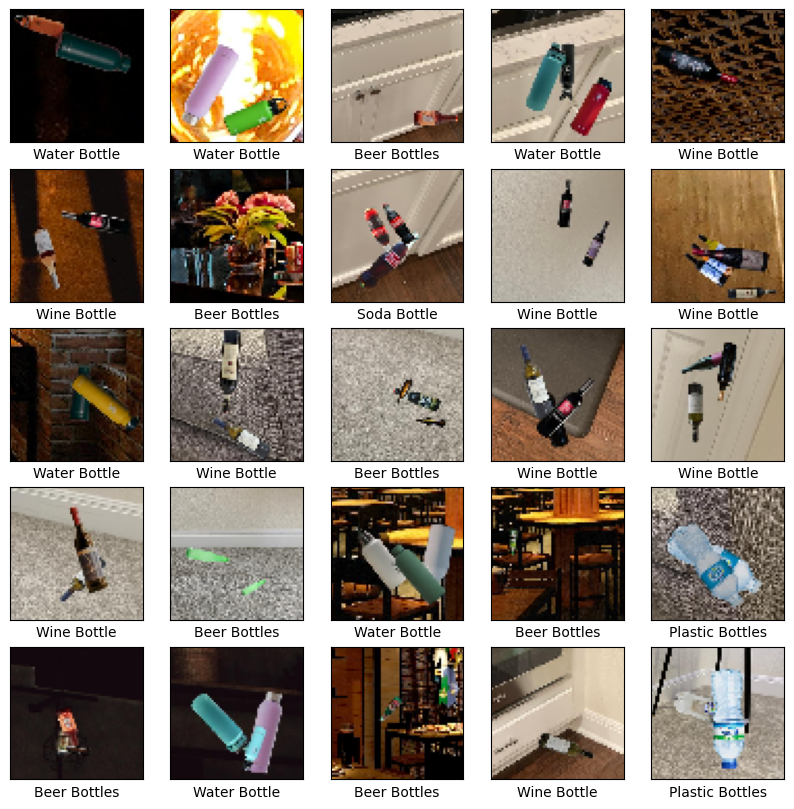

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    plt.xlabel(str(y_train[i]))
plt.show()

### Label Encoding
**Preprocesses categorical target values**

As the labels are categorical we have to use label encoding.
Following code encodes labels as integers.


In [ ]:
label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
# to_categorical converts the integer labels that comes from label encoder,
# into a one-hot encoded representation
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

y_train shape: (12000, 5)
y_test shape: (3000, 5)


### Train the best DNN model
Optimal model that I found uses Conv2D that directly handles 2D image data followed by MaxPooling2D layer.

I used activation ReLU and activation softmax.
- ReLU -> introduces non-linearity
- Softmax -> ensures that the output numbers sum to one and represent probability for each bottle type

In [ ]:
model = tf.keras.Sequential([
      tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
      tf.keras.layers.MaxPooling2D((2, 2)),
      tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
      tf.keras.layers.MaxPooling2D((2, 2)),
      tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
      tf.keras.layers.MaxPooling2D((2, 2)),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(len(df_train['Bottle Type'].unique()), activation='softmax')
])

### Compile the model
The model is compiled with the **categorical crossentropy** as a loss function (Because target label, Bottle Type, is one hot encoded), **RMSprop** as optimizer, and **accuracy** as evaluation metric.

In [ ]:
model.compile(optimizer='RMSprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Define Early Stopping
Early stopping helps prevent overfitting and leads to resource savings as it stops training patiently 5.

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

### Fit the model
As I used validation_split=0.2, the model will automatically split the training data into training and validation sets based on 0.2 for validation 0.8 for training.

In [ ]:
model.fit(X_train, y_train, epochs=15, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/15
300/300 [==============================] - 67s 225ms/step - loss: 0.2222 - accuracy: 0.9250 - val_loss: 0.3653 - val_accuracy: 0.8733
Epoch 2/15
300/300 [==============================] - 66s 220ms/step - loss: 0.1799 - accuracy: 0.9434 - val_loss: 0.3649 - val_accuracy: 0.8808
Epoch 3/15
300/300 [==============================] - 66s 220ms/step - loss: 0.1342 - accuracy: 0.9541 - val_loss: 0.3505 - val_accuracy: 0.8883
Epoch 4/15
300/300 [==============================] - 71s 236ms/step - loss: 0.1226 - accuracy: 0.9601 - val_loss: 0.3698 - val_accuracy: 0.8913
Epoch 5/15
300/300 [==============================] - 71s 236ms/step - loss: 0.0926 - accuracy: 0.9718 - val_loss: 0.4012 - val_accuracy: 0.8842
Epoch 6/15
300/300 [==============================] - 68s 226ms/step - loss: 0.0820 - accuracy: 0.9769 - val_loss: 0.4000 - val_accuracy: 0.8888
Epoch 7/15
300/300 [==============================] - 66s 219ms/step - loss: 0.0704 - accuracy: 0.9809 - val_loss: 0.4265 - val_ac

### Model Evaluation
The deep learning model achieved **0.89** accuracy.

In [ ]:
predictions = model.predict(X_test)
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)
print('\nAccuracy:', test_acc)

94/94 [==============================] - 15s 155ms/step
94/94 - 9s - loss: 0.3613 - accuracy: 0.8970 - 9s/epoch - 99ms/step

Accuracy: 0.8970000147819519


### Experiments
The table below compares different experiments conducted to arrive at the best model. It highlights the key differences between each experiment and the final, optimal model.

**Optimal Model**
  - Number of Layers : 9 -> (Conv2D, MaxPooling2D, Conv2D, MaxPooling2D, Conv2D,
 MaxPooling2D, Flatten, Dense, Dense)

  - Number of Epoch : 15

  - Optimizer : RMSprop

  - Consists Early Stopping

  - Accuracy: 0.89


*Loss function didn't change. Because my label is one hot encoded. Thus, I can only use categorical crossentropy.*

***'-' means no difference between the optimal model.***

|          | Model 1  | Model 2  | Model 3  | Model 4  | Model 5  | Model 6  | Model 7  |Model 8  |Model 9  |Model 10  |
|----------|----------|----------|----------|----------|----------|----------|----------|----------|----------|----------|
|Accuracy  |0.83|0.18|0.17|0.59|0.60|0.19|0.83|0.86|0.85|0.87|
|Optimizer |adam|adam|RMSprop|adam|RMSprop|RMSprop|adam|RMSprop|adam|RMSprop|
|Number of <br>Layers|-|4 layers <br> (Flatten, Dense,<br>  BatchNormalization,<br>Dense, Dense)|Same with <br>Model 1 |6 layers <br> (Conv2D, MaxPooling2D,<br>  Conv2D, Flatten,<br>  Dense, Dense)|Same with<br> Model 3|-|13 layers(Conv2D,<br> BatchNormalization,<br> MaxPooling2D, <br>Conv2D, BatchNormalization, <br>MaxPooling2D, Conv2D, <br> BatchNormalization, <br>MaxPooling2D, <br>Flatten, Dense, <br>BatchNormalization, Dense)| same with<br> model 7|-|-|
|Input <br>Layers|-|Flatten layer|Same with <br>Model 1 |-|-|-|-|-|-|-|
|Layer<br> Types|-|Consists only Dense and <br> batch normalization layers|Same with <br>Model 1 |Two Conv2D,<br>  each followed by <br> a MaxPooling2D layer.|Same with<br> Model 3|-|adding BatchNormalization<br> layer into the optimal model| same with<br> model 7|-|-|
|Output <br> Layers|-|No activation function|Same with <br>Model 1|-|-|No activation function|-|-|-|-|
|Other differences|-|-|-|-|-|-|-|-|Changed *number of Epoch* to 10|Added checkpoint_callback<br>|


## Overall Discussion

**Strenghts**

- Identify recyclable bottles from waste and categorize them easily. It does not require a human nor a big machine. Once trained, the model can be deployed across multiple recycling kiosks.

**Limitations**

- The dataset may not accurately represent current bottle shapes/types because it has limited number of pictures.

- Particularly with the introduction of new types of recyclable materials, continuous monitoring and updating of the model may be necessary to ensure sustainable, constant, and high performance.

**Implications**

- Could lead to higher quality recycling outputs.

- Businesses can significantly reduce processing times.

**Data-driven Recommendations**

- Enhance the dataset with real-world images to improve model usability and generalizability -> means Data Augmentation.

- Target particular bottle type with strong demand and update their images accordingly.

